In [ ]:
#import libraries
from fastai.tabular.all import *
from fastai.collab import *
import pandas as pd

In [ ]:
#load data
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_small.csv')
metadata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movies_metadata.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#we will select movies with at least 50 votes, 80th percentile of votes
metadata_cf = metadata[metadata['vote_count']>=50][['id','title']]

#to select IDs of movies with vote count more than 50 in metadata_cf
movie_ids = [int(x) for x in metadata_cf['id'].values]

#select ratings of movies with more than 50 vote counts
ratings = ratings[ratings['movieId'].isin(movie_ids)][['userId','movieId', 'rating']]

#to reset index
ratings.reset_index(inplace=True, drop=True)

#movieId in ratings = id in metadata_cf, drop id column 
metadata_cf['movieId'] = metadata_cf['id'].astype(int)
metadata_cf = metadata_cf.drop('id', axis=1)

#merge ratings and metadata_cf to get title of movie as well
ratings = ratings.merge(metadata_cf)
ratings.head()

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III


In [ ]:
#By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. 
#We need to change the value of item_name in our case, to use the titles instead of the ids
#bs = batch size, how many samples per batch to load

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [ ]:
#assemble data with data loader and view with show batch
dls.show_batch()

,userId,title,rating
0,184,Minority Report,3.0
1,580,The Arrival of a Train at La Ciotat,1.5
2,220,Rope,4.0
3,118,Persepolis,5.0
4,119,Parenthood,3.0
5,426,The Talented Mr. Ripley,4.0
6,516,Dial M for Murder,3.0
7,56,Married to the Mob,4.0
8,67,Donnie Darko,1.0
9,388,Fahrenheit 9/11,3.0


In [ ]:
#fastai can create and train a collaborative filtering model by using collab_learner:
#n_factors default is 50, y_range is the rating of 0-5
#it uses a simple dot product model with 50 latent factors
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=rmse)

SuggestedLRs(valley=0.005248074419796467)

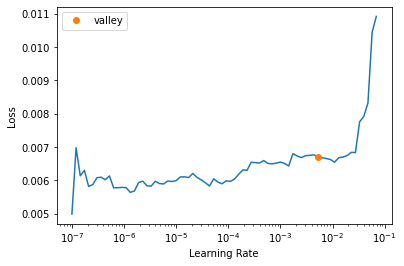

In [ ]:
#to find the lowest loss with optimal learning rate
#to use LR of 0.005
learn.lr_find()

In [ ]:
#To train it using the 1cycle policy, we just run this command
#small weight decay wd of 0.1 for regularization
#best RMSE score of 0.86
learn.fit_one_cycle(5, 0.005, wd=0.1)

epoch,train_loss,valid_loss,_rmse,time
0,1.035811,0.895508,0.946313,00:06
1,0.768211,0.766774,0.875656,00:03
2,0.582441,0.739534,0.859962,00:03
3,0.445057,0.739053,0.859682,00:03
4,0.347999,0.740394,0.860461,00:03


In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(670, 50)
  (i_weight): Embedding(1427, 50)
  (u_bias): Embedding(670, 1)
  (i_bias): Embedding(1427, 1)
)

In [ ]:
#make predictions

movie_names = list(metadata_cf.drop_duplicates(subset='movieId', keep='first').title)
size = len(movie_names)

def predict_top_movies(userId, count=5):
  query = { 'userId': [userId] * size, 'title': movie_names }
  query_df = pd.DataFrame(data=query)
  query_dl = dls.test_dl(query_df)
  preds, y = learn.get_preds(dl=query_dl)
  results = sorted(zip(preds, movie_names), reverse=True)[:count]
  for idx, (score, name) in enumerate(results):
    print("Score: ", round(float(score), 2), " for movie: ", name)

def predict_user_rating(userId, movieName):
  query = { 'userId': [userId] * size, 'title': [movieName] * size}
  query_df = pd.DataFrame(data=query)
  query_dl = dls.test_dl(query_df)
  preds, y = learn.get_preds(dl=query_dl)
  results = sorted(zip(preds, [movieName]), reverse=True)
  for idx, (score, name) in enumerate(results):
    print("Score: ", round(float(score), 2), " for movie: ", movieName)

predict_top_movies(123)
print(" ")
predict_user_rating(123, 'Minions')

Score:  4.78  for movie:  The Million Dollar Hotel
Score:  4.69  for movie:  Monsoon Wedding
Score:  4.68  for movie:  High Noon
Score:  4.64  for movie:  A Very Long Engagement
Score:  4.62  for movie:  A River Runs Through It
 


Score:  3.16  for movie:  Minions
